<a href="https://colab.research.google.com/github/Amgad-Abdelkhaleq/Arabic-Egyptian-Sentiment-Analysis/blob/main/Arabic_egy_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import nltk
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.models import load_model
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
ar_stopwords = '''
أنفسنا مثل حيث ذلك بشكل لدى ألا عن إلي ب لنا وقالت فقط الذي الذى ا هذا غير أكثر اي أنا أنت ايضا اذا كيف وكل أو اكثر أي أن منه وكان وفي تلك إن سوف حين نفسها هكذا قبل حول منذ هنا عندما على ضمن لكن فيه عليه قليل صباحا لهم بان يكون بأن أما هناك مع فوق بسبب ما لا هذه و فيها ف ولم ل آخر ثانية انه من الان جدا به بن بعض حاليا بها هم أ كانت هي لها نحن تم أنفسهم ينبغي إلى فان وقد تحت' عند وجود الى فأن الي او قد خارج إنه اى مرة هؤلاء أنها إذا فهي فهى كل يمكن جميع أنفسكم فعل كان ثم لي الآن وقال فى في ديك لم لن له تكون الذين ليس التى التي أنه وان بعد حتى ان دون وأن لماذا يجري كلا إنها لك ضد وإن فهو انها منها أى لديه ولا بين خلال وما اما عليها بعيدا كما نفسي نحو هو نفسك نفسه انت ولن إضافي لقاء وكانت هى فما أيضا إلا معظم ومن إما الا بينما وهي وهو وهى
'''

ar_stopwords=nltk.word_tokenize(ar_stopwords)
print("length of stopwords is: ",len(ar_stopwords))


length of stopwords is:  179


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
def process_text(text):
    stemmer = nltk.ISRIStemmer()
    word_list = nltk.word_tokenize(text)
    #remove arabic stopwords
    word_list = [ w for w in word_list if not w in ar_stopwords ]
    #remove digits
    word_list = [ w for w in word_list if not w.isdigit() ]
    #stemming
    word_list = [stemmer.stem(w) for w in  word_list]
    return ' '.join(word_list) 


def clean_text(text):  

    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",
              "\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","ي","",' ', ' ',' ',' ? ',' ؟ ', ' ! ']
    #remove tashkeel
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)
  
    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)
    
    text = re.sub(r"[^\w\s]", '', text)
    #remove english words
    text = re.sub(r"[a-zA-Z]", '', text)
    #remove spaces
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    #remove repetetions
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    text = text.strip()
    
    return process_text(text) 


In [ ]:
data = pd.read_csv('DATA_SET_CP.csv')
data.columns = ['text','sentiment']
# exclude nutral sentiments
data = data[data.sentiment.isin([-1, 1])]
data.head()

,text,sentiment
0,عملي,1
2,اشتريت السلعه ودفعت ثمنها من الماستر كارد وتم ابلاغي انه تم ارجاعها ولا اعلم السبب,-1
3,شنطة جميلة وأنيقة وسعرها مناسب جدا,-1
4,حلوه,1
5,هذا السرير (أو المحجر كما يسمى) ممتاز ... نوم ولعب بأمان خاصة للأطفال الرضع أقل من 3 سنوات.,1


In [ ]:
data['cleaned_text'] = data.text.apply(clean_text)
data = data[data.cleaned_text != ""]
data.head(10)

,text,sentiment,cleaned_text
0,عملي,1,عمل
2,اشتريت السلعه ودفعت ثمنها من الماستر كارد وتم ابلاغي انه تم ارجاعها ولا اعلم السبب,-1,شري سلع دفع ثمن استر كرد وتم بلغ رجع علم سبب
3,شنطة جميلة وأنيقة وسعرها مناسب جدا,-1,شنط جمل انق سعر نسب
4,حلوه,1,حله
5,هذا السرير (أو المحجر كما يسمى) ممتاز ... نوم ولعب بأمان خاصة للأطفال الرضع أقل من 3 سنوات.,1,سرر حجر يسم متز نوم لعب بام خصه طفل رضع اقل سنو
6,مفيده,1,فيد
7,مرااا حلوة احلى شيء انها تجمع اكتر من شيء بمكان واحد يعني اغتنام مساحهة ومنظمة ومرتبة وكل شي قريب من البيبي .. واجهت صعوبة بس في فتح السرير .. والطريقة كانت واضحة باليوتيوب اكتبو طريقة تركيب سرير الاطفال,1,مرا حله احل شيء جمع كتر شيء بمك وحد يعن غنم سحه نظم رتب شي قرب بيب وجه صعب بس فتح سرر طرق وضح تيب كبو طرق ركب سرر طفل
8,هذه السلعه ممتازة جدا وفريدة من نوعها,1,سلع متز فرد نوع
10,تم توصيل السلعة الى المنزل بحالة ممتازه في وقت قصير وهي اداة مفيدة جدا لإراحة الأهل من تفقد الأطفال كل فترة,1,وصل سلع نزل بحل متز وقت قصر اده فيد ارح اهل فقد طفل فتر
11,منتج رائع جداً وانصح فيه,1,نتج رئع نصح


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


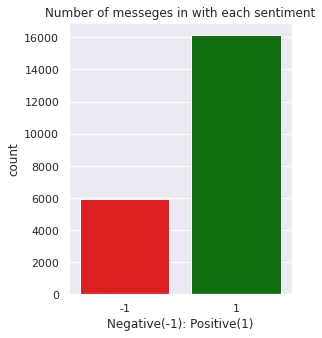

In [ ]:
min_sample = data.groupby(['sentiment']).count().text.min()
input_data = pd.concat([data[data.sentiment == 1].head(min_sample), 
                        data[data.sentiment == -1].head(min_sample)])

sns.set_style('darkgrid')
plt.figure(figsize=(4, 5))
sns.countplot(data['sentiment'], palette=['red', 'green'])
plt.title('Number of messeges in with each sentiment')
plt.xlabel("Negative(-1): Positive(1)")
plt.show()

In [ ]:
X = input_data.cleaned_text.values #training paramter
Y = np.asarray(input_data.sentiment.values).astype('float32') #prediction paramter
Y = Y.clip(0, 1)

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
print("vocab size:",len(tokenizer.word_index))
X = pad_sequences(X, padding='post', maxlen=300)

vocab size: 13286


In [ ]:
X_train, X_test, label_train, label_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("Training:", len(X_train))
print("Testing: ", len(X_test))

Training: 8328
Testing:  3570


In [ ]:
#create LSTM model with keras
embedding_dim = 100
dropout = 0.5
opt = 'adam'
clear_session()
model = Sequential()
model.add(layers.Embedding(input_dim=20000, 
                           output_dim=100, 
                           input_length=300))
model.add(layers.Bidirectional(layers.LSTM(100, dropout=0.5, 
                                           recurrent_dropout=0.5, 
                                           return_sequences=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
history = model.fit(X_train, label_train,
                    epochs=4,
                    verbose=True,
                    validation_data=(X_test, label_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, label_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss_val, accuracy_val = model.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/4
131/131 [==============================] - 231s 2s/step - loss: 0.7016 - accuracy: 0.5328 - val_loss: 0.5637 - val_accuracy: 0.6798
Epoch 2/4
131/131 [==============================] - 233s 2s/step - loss: 0.3940 - accuracy: 0.8499 - val_loss: 0.2602 - val_accuracy: 0.8947
Epoch 3/4
131/131 [==============================] - 229s 2s/step - loss: 0.2198 - accuracy: 0.9293 - val_loss: 0.2300 - val_accuracy: 0.9104
Epoch 4/4
261/261 [==============================] - 41s 156ms/step - loss: 0.0977 - accuracy: 0.9655
Training Accuracy: 0.9655
112/112 [==============================] - 17s 156ms/step - loss: 0.2642 - accuracy: 0.9036
Testing Accuracy:  0.9036


In [ ]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


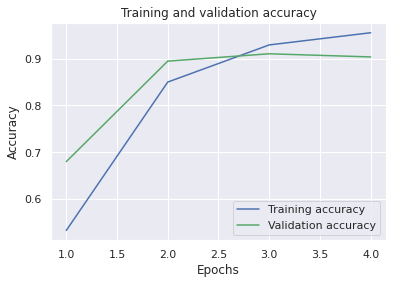

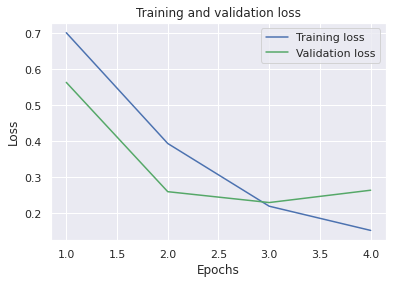

In [ ]:
plot_history(history)

In [ ]:
#save model
model.save('model.h5')

In [ ]:
def feedback_learing(text,correct_pred):
  X=clean_text(text)
  tokenizer.fit_on_texts(X)
  X = tokenizer.texts_to_sequences(X)
  X = pad_sequences(X, padding='post', maxlen=300)
  Y = np.asarray(correct_pred).astype('float32').reshape((-1,1))
  print(model.train_on_batch(X,Y))
  model.save('model.h5')


[0.26442912220954895, 0.9006973505020142]


In [ ]:
def predict_sentiment(input):
  input=clean_text(input)
  model_input=tokenizer.texts_to_sequences(input)
  model_input=pad_sequences(model_input, padding='post', maxlen=300)
  pred = model.predict(model_input, verbose=True)
  pred=pred.reshape(pred.shape[0],)[0]
  if(pred>0.5): return "Satisfied",pred
  return "Unsatisfied",pred
 

In [ ]:
if __name__ == "__main__":
  while(True):
    user_messege=input("Hi, please enter a message to test model prediction: ")
    pred,score=predict_sentiment(user_messege)
    print(pred,'\n',"score: ",score)
    feedback=input("Was it the correct prediction? [Y/N]")
    if(feedback=='N'):
      if(pred=="Satisfied"): feedback_learing(user_messege,0) 
      else:  feedback_learing(user_messege,1)

7/7 [==============================] - 1s 126ms/step
Unsatisfied 
 score:  0.40435666
1/1 [==============================] - 0s 2ms/step
Unsatisfied 
 score:  0.4669529
1/1 [==============================] - 0s 2ms/step
Unsatisfied 
 score:  0.40435666
1/1 [==============================] - 0s 1ms/step
Satisfied 
 score:  0.5999802
1/1 [==============================] - 0s 2ms/step
Satisfied 
 score:  0.64582694
2/2 [==============================] - 0s 46ms/step
Satisfied 
 score:  0.5999802
1/1 [==============================] - 0s 1ms/step
Satisfied 
 score:  0.5342141
[0.6682041883468628, 0.6363636255264282]
1/1 [==============================] - 0s 2ms/step
Unsatisfied 
 score:  0.47690475
